In [ ]:
# Yapabildigimiz en gelismis RANSAC.
# USAC algoritmalari da olsa iyi olur. Ama pek gercekci degil.

# NumPy'a dependency olacak.
# Belki OpenCV'ye de olabilir ama findHomography fonksiyonuna degil!

# Sampling: Uniform, PROSAC.
# Score: RANSAC, MSAC, LMeds.
# Error metric: re-projection distance, symmetric reprojection distance.
# Degeneracy: Collinearity test  
# SPRT verification
# Local Optimization: ?

# NONE_POLISHER, LSQ_POLISHER

Inlier count: 106
Error: 2.52 pixels


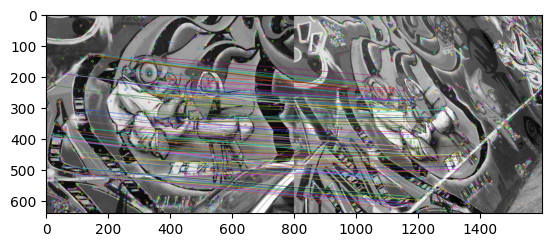

In [7]:
from utils import *

import random

from numba import njit


def geometric_distance(x1, y1, x2, y2, H):
    # We implement "transfer error".
    # See "Error in one image." from Multiple View Geometry in Computer Vision, 2nd Edition, page 94.
    # Euclidean distance between real (x2, y2) and estimated (x2, y2).

    # TODO: Burayi iyilestir. (Symmetric falan.)
    estimated_x2, estimated_y2 = cv.perspectiveTransform(np.array([[[x1, y1]]], dtype=np.float32), H)[0][0]
    return euclidean_distance(x2, y2, estimated_x2, estimated_y2)


def minimal_solver(matches, kp1, kp2):
    match_sample = np.random.choice(matches, 4, replace=False)
    src_pts = np.array([kp1[m.queryIdx].pt for m in match_sample], dtype=np.float32).reshape(-1, 1, 2)
    dst_pts = np.array([kp2[m.trainIdx].pt for m in match_sample], dtype=np.float32).reshape(-1, 1, 2) 
    H = cv.getPerspectiveTransform(src_pts, dst_pts)
    return H


def find_homography(matches, kp1, kp2, threshold=3, iteration_count=1000, polish=True, minimal_solver=minimal_solver):
    best_inlier_list = []
    best_H = None

    # TODO: Threadler kullanmayi dene. (ASIFT'te oldugu gibi)
    # TODO: AdaLAM'deki gibi RANSAC'ler dene. (PyTorch, mumkunse GPU)
    # TODO: SPRT gibi iyilestirmeleri yap.
    # TODO: Inner RANSAC gibi bir local optimization dene.
    for _ in range(iteration_count):
        H = minimal_solver(matches, kp1, kp2)

        # TODO: If H is None then continue

        inlier_list = []
        for match in matches:
            keypoint1 = kp1[match.queryIdx]
            keypoint2 = kp2[match.trainIdx]

            error = geometric_distance(*keypoint1.pt, *keypoint2.pt, H)
            if error < threshold:
                inlier_list.append(match)

        if len(inlier_list) > len(best_inlier_list):
            best_inlier_list = inlier_list
            best_H = H

    if polish:
        pts1_inliers = np.array([kp1[m.queryIdx].pt for m in best_inlier_list], dtype=np.float32).reshape(-1, 1, 2)
        pts2_inliers = np.array([kp2[m.trainIdx].pt for m in best_inlier_list], dtype=np.float32).reshape(-1, 1, 2)
        best_H, _ = cv.findHomography(pts1_inliers, pts2_inliers, method=0)

    return best_H, best_inlier_list 



img1_no = 1
img2_no = 4

img1_path = f'homography_dataset/img{img1_no}.png'
img2_path = f'homography_dataset/img{img2_no}.png'
h_path = f'homography_dataset/H{img1_no}to{img2_no}p'

img1 = read_image(img1_path, is_grayscale=True)
img2 = read_image(img2_path, is_grayscale=True)

sift = cv.SIFT_create(2000)
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

H_estimated, matches_inliers = find_homography(matches, kp1, kp2, threshold=3, iteration_count=10_000, polish=True)
print("Inlier count:", len(matches_inliers))

if img1_no == img2_no:
    H_true = np.eye(3)
else:
    H_true = np.loadtxt(h_path)

print('Error:', round(average_corner_error(*img1.shape, H_true, H_estimated), 3), 'pixels')

show_image(cv.drawMatches(img1, kp1, img2, kp2, matches_inliers, None))


In [ ]:
# Guided match gibi basit bir fikir geldi aklima. 
# Polish yaptiktan sonra bunu support edenler tekrar bulunabilir ve tekrar polish edilebilir bunlarla.
# Hatta o adimda homography-from-two-correspondences'taki gibi zenginlestirme de olabilir.
# Belki threshold dusurulebilir.

# Coarse to fine RANSAC gibi bir makale vardi.
# RANSAC'ten (GC-RANSAC'ten) cikanlari tekrar LMedS'e sokuyorlardi.
# Threshold'u biraz yuksek tutup sonra threshold dusurup LMedS mi yapsak acaba? (LMedS'in threshold'u var mi?)